In [1]:
!pip install --upgrade quantecon

In [2]:
import numpy as np
import numpy.linalg as la
import quantecon as qe
from quantecon import LQ
import matplotlib.pyplot as plt

In [3]:
# Parameters
a0 = 10
a1 = 2
β = 0.96
γ = 120
n = 300
tol0 = 1e-8
tol1 = 1e-16
tol2 = 1e-2

βs = np.ones(n)
βs[1:] = β
βs = βs.cumprod()

In [4]:
# In LQ form
Alhs = np.eye(4)

# Euler equation coefficients
Alhs[3, :] = β * a0 / (2 * γ), -β * a1 / (2 * γ), -β * a1 / γ, β

Arhs = np.eye(4)
Arhs[2, 3] = 1

Alhsinv = la.inv(Alhs)

A = Alhsinv @ Arhs

B = Alhsinv @ np.array([[0, 1, 0, 0]]).T

R = np.array([[0,      -a0 / 2,      0, 0],
              [-a0 / 2,     a1, a1 / 2, 0],
              [0,       a1 / 2,      0, 0],
              [0,            0,      0, 0]])

Q = np.array([[γ]])

# Solve using QE's LQ class
# LQ solves minimization problems which is why the sign of R and Q was changed
lq = LQ(Q, R, A, B, beta=β)
P, F, d = lq.stationary_values(method='doubling')

P22 = P[3:, 3:]
P21 = P[3:, :3]
P22inv = la.inv(P22)
H_0_0 = -P22inv @ P21

# Simulate forward

π_leader = np.zeros(n)

z0 = np.array([[1, 1, 1]]).T
x0 = H_0_0 @ z0
y0 = np.vstack((z0, x0))

yt, ut = lq.compute_sequence(y0, ts_length=n)[:2]

π_matrix = (R + F. T @ Q @ F)

for t in range(n):
    π_leader[t] = -(yt[:, t].T @ π_matrix @ yt[:, t])

# Display policies
print("Computed policy for Continuation Stackelberg leader\n")
print(f"F = {F}")

Computed policy for Continuation Stackelberg leader

F = [[-1.58004454  0.29461313  0.67480938  6.53970594]]


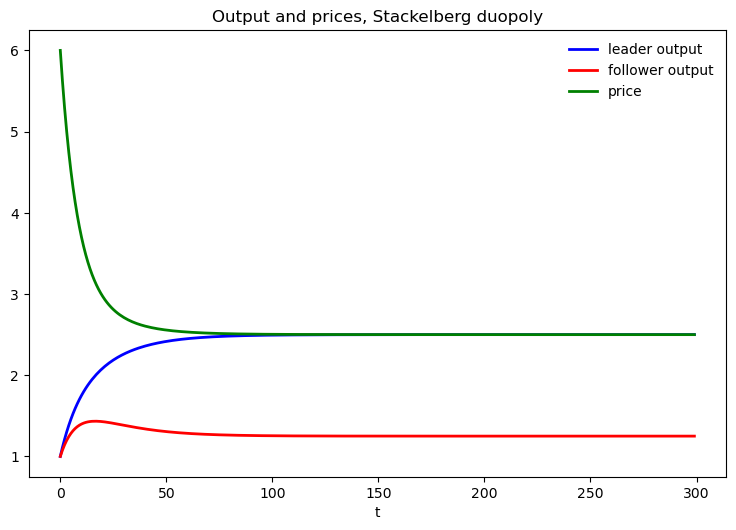

In [5]:
q_leader = yt[1, :-1]
q_follower = yt[2, :-1]
q = q_leader + q_follower       # Total output, Stackelberg
p = a0 - a1 * q                 # Price, Stackelberg

fig, ax = plt.subplots(figsize=(9, 5.8))
ax.plot(range(n), q_leader, 'b-', lw=2, label='leader output')
ax.plot(range(n), q_follower, 'r-', lw=2, label='follower output')
ax.plot(range(n), p, 'g-', lw=2, label='price')
ax.set_title('Output and prices, Stackelberg duopoly')
ax.legend(frameon=False)
ax.set_xlabel('t')
plt.show()

In [6]:
v_leader_forward = np.sum(βs * π_leader)
v_leader_direct = -yt[:, 0].T @ P @ yt[:, 0]

# Display values
print("Computed values for the Stackelberg leader at t=0:\n")
print(f"v_leader_forward(forward sim) = {v_leader_forward:.4f}")
print(f"v_leader_direct (direct) = {v_leader_direct:.4f}")

Computed values for the Stackelberg leader at t=0:

v_leader_forward(forward sim) = 150.0316
v_leader_direct (direct) = 150.0324


In [7]:
# Manually checks whether P is approximately a fixed point
P_next = (R + F.T @ Q @ F + β * (A - B @ F).T @ P @ (A - B @ F))
(P - P_next < tol0).all()

True

In [8]:
# Manually checks whether two different ways of computing the
# value function give approximately the same answer
v_expanded = -((y0.T @ R @ y0 + ut[:, 0].T @ Q @ ut[:, 0] +
               β * (y0.T @ (A - B @ F).T @ P @ (A - B @ F) @ y0)))
(v_leader_direct - v_expanded < tol0)[0, 0]

True

In [9]:
# Compute value function over time with a reset at time t
vt_leader = np.zeros(n)
vt_reset_leader = np.empty_like(vt_leader)

yt_reset = yt.copy()
yt_reset[-1, :] = (H_0_0 @ yt[:3, :])

for t in range(n):
    vt_leader[t] = -yt[:, t].T @ P @ yt[:, t]
    vt_reset_leader[t] = -yt_reset[:, t].T @ P @ yt_reset[:, t]

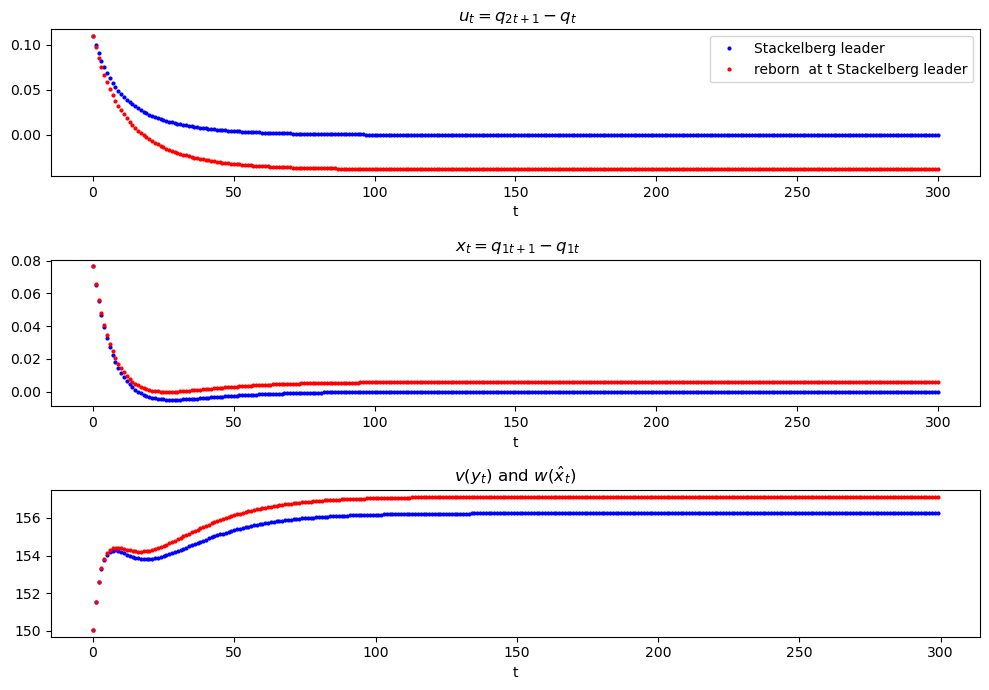

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(10, 7))

axes[0].plot(range(n+1), (- F @ yt).flatten(), 'bo',
    label='Stackelberg leader', ms=2)
axes[0].plot(range(n+1), (- F @ yt_reset).flatten(), 'ro',
    label='reborn  at t Stackelberg leader', ms=2)
axes[0].set(title=r' $u_{t} = q_{2t+1} - q_t$', xlabel='t')
axes[0].legend()

axes[1].plot(range(n+1), yt[3, :], 'bo', ms=2)
axes[1].plot(range(n+1), yt_reset[3, :], 'ro', ms=2)
axes[1].set(title=r' $x_{t} = q_{1t+1} - q_{1t}$', xlabel='t')

axes[2].plot(range(n), vt_leader, 'bo', ms=2)
axes[2].plot(range(n), vt_reset_leader, 'ro', ms=2)
axes[2].set(title=r'$v(y_{t})$ and $w(\hat x_t)$', xlabel='t')

plt.tight_layout()
plt.show()

In [11]:
A_tilde = np.eye(5)
A_tilde[:4, :4] = A - B @ F

R_tilde = np.array([[0,            0, 0,    0, -a0 / 2],
                    [0,            0, 0,    0,  a1 / 2],
                    [0,            0, 0,    0,       0],
                    [0,            0, 0,    0,       0],
                    [-a0 / 2, a1 / 2, 0,    0,      a1]])

Q_tilde = Q
B_tilde = np.array([[0, 0, 0, 0, 1]]).T

lq_tilde = LQ(Q_tilde, R_tilde, A_tilde, B_tilde, beta=β)
P_tilde, F_tilde, d_tilde = lq_tilde.stationary_values(method='doubling')

y0_tilde = np.vstack((y0, y0[2]))
yt_tilde = lq_tilde.compute_sequence(y0_tilde, ts_length=n)[0]

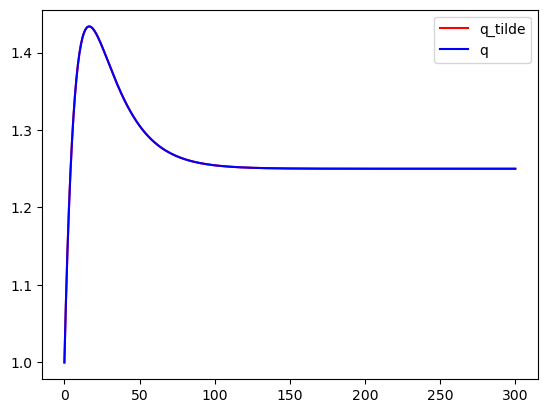

In [12]:
# Checks that the recursive formulation of the follower's problem gives
# the same solution as the original Stackelberg problem
fig, ax = plt.subplots()
ax.plot(yt_tilde[4], 'r', label="q_tilde")
ax.plot(yt_tilde[2], 'b', label="q")
ax.legend()
plt.show()

In [13]:
# Maximum absolute difference in quantities over time between
# the first and second solution methods
np.max(np.abs(yt_tilde[4] - yt_tilde[2]))

6.661338147750939e-16

In [14]:
# x0 == x0_tilde
yt[:, 0][-1] - (yt_tilde[:, 1] - yt_tilde[:, 0])[-1] < tol0

True

In [15]:
# Policy function in the follower's problem
F_tilde.round(4)

array([[-0.    , -0.    , -0.1032, -1.    ,  0.1032]])

In [16]:
# Value function in the Stackelberg problem
P

array([[  963.54083615,  -194.60534465,  -511.62197962, -5258.22585724],
       [ -194.60534465,    37.3535753 ,    81.97712513,   784.76471234],
       [ -511.62197962,    81.97712513,   247.34333344,  2517.05126111],
       [-5258.22585724,   784.76471234,  2517.05126111, 25556.16504097]])

In [17]:
# Value function in the follower's problem
P_tilde

array([[-1.81991134e+01,  2.58003020e+00,  1.56048755e+01,
         1.51229815e+02, -5.00000000e+00],
       [ 2.58003020e+00, -9.69465925e-01, -5.26007958e+00,
        -5.09764310e+01,  1.00000000e+00],
       [ 1.56048755e+01, -5.26007958e+00, -3.22759027e+01,
        -3.12791908e+02, -1.23823802e+01],
       [ 1.51229815e+02, -5.09764310e+01, -3.12791908e+02,
        -3.03132584e+03, -1.20000000e+02],
       [-5.00000000e+00,  1.00000000e+00, -1.23823802e+01,
        -1.20000000e+02,  1.43823802e+01]])

In [18]:
# Manually check that P is an approximate fixed point
(P  - ((R + F.T @ Q @ F) + β * (A - B @ F).T @ P @ (A - B @ F)) < tol0).all()

True

In [19]:
# Compute `P_guess` using `F_tilde_star`
F_tilde_star = -np.array([[0, 0, 0, 1, 0]])
P_guess = np.zeros((5, 5))

for i in range(1000):
    P_guess = ((R_tilde + F_tilde_star.T @ Q @ F_tilde_star) +
               β * (A_tilde - B_tilde @ F_tilde_star).T @ P_guess
               @ (A_tilde - B_tilde @ F_tilde_star))

In [20]:
# Value function in the follower's problem
-(y0_tilde.T @ P_tilde @ y0_tilde)[0, 0]

112.65590740578122

In [21]:
# Value function with `P_guess`
-(y0_tilde.T @ P_guess @ y0_tilde)[0, 0]

112.6559074057813

In [22]:
# Compute policy using policy iteration algorithm
F_iter = (β * la.inv(Q + β * B_tilde.T @ P_guess @ B_tilde)
          @ B_tilde.T @ P_guess @ A_tilde)

for i in range(100):
    # Compute P_iter
    P_iter = np.zeros((5, 5))
    for j in range(1000):
        P_iter = ((R_tilde + F_iter.T @ Q @ F_iter) + β
                  * (A_tilde - B_tilde @ F_iter).T @ P_iter
                  @ (A_tilde - B_tilde @ F_iter))

    # Update F_iter
    F_iter = (β * la.inv(Q + β * B_tilde.T @ P_iter @ B_tilde)
              @ B_tilde.T @ P_iter @ A_tilde)

dist_vec = (P_iter - ((R_tilde + F_iter.T @ Q @ F_iter)
            + β * (A_tilde - B_tilde @ F_iter).T @ P_iter
            @ (A_tilde - B_tilde @ F_iter)))

if np.max(np.abs(dist_vec)) < 1e-8:
    dist_vec2 = (F_iter - (β * la.inv(Q + β * B_tilde.T @ P_iter @ B_tilde)
                 @ B_tilde.T @ P_iter @ A_tilde))

    if np.max(np.abs(dist_vec2)) < 1e-8:
        F_iter
    else:
        print("The policy didn't converge: try increasing the number of \
            outer loop iterations")
else:
    print("`P_iter` didn't converge: try increasing the number of inner \
        loop iterations")

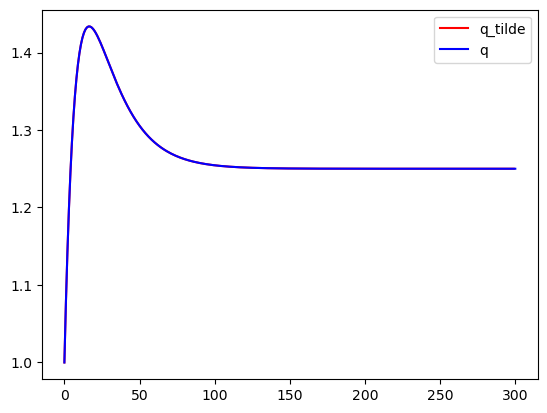

In [23]:
# Simulate the system using `F_tilde_star` and check that it gives the
# same result as the original solution

yt_tilde_star = np.zeros((n, 5))
yt_tilde_star[0, :] = y0_tilde.flatten()

for t in range(n-1):
    yt_tilde_star[t+1, :] = (A_tilde - B_tilde @ F_tilde_star) \
        @ yt_tilde_star[t, :]

fig, ax = plt.subplots()
ax.plot(yt_tilde_star[:, 4], 'r', label="q_tilde")
ax.plot(yt_tilde[2], 'b', label="q")
ax.legend()
plt.show()

In [24]:
# Maximum absolute difference
np.max(np.abs(yt_tilde_star[:, 4] - yt_tilde[2, :-1]))

8.881784197001252e-16

In [25]:
# In LQ form
A = np.eye(3)
B1 = np.array([[0], [0], [1]])
B2 = np.array([[0], [1], [0]])

R1 = np.array([[0,            0, -a0 / 2],
               [0,            0,  a1 / 2],
               [-a0 / 2, a1 / 2,      a1]])

R2 = np.array([[0,       -a0 / 2,      0],
               [-a0 / 2,      a1, a1 / 2],
               [0,        a1 / 2,      0]])

Q1 = Q2 = γ
S1 = S2 = W1 = W2 = M1 = M2 = 0.0

# Solve using QE's nnash function
F1, F2, P1, P2 = qe.nnash(A, B1, B2, R1, R2, Q1,
                          Q2, S1, S2, W1, W2, M1,
                          M2, beta=β, tol=tol1)

# Simulate forward
AF = A - B1 @ F1 - B2 @ F2
z = np.empty((3, n))
z[:, 0] = 1, 1, 1
for t in range(n-1):
    z[:, t+1] = AF @ z[:, t]

# Display policies
print("Computed policies for firm 1 and firm 2:\n")
print(f"F1 = {F1}")
print(f"F2 = {F2}")

Computed policies for firm 1 and firm 2:

F1 = [[-0.22701363  0.03129874  0.09447113]]
F2 = [[-0.22701363  0.09447113  0.03129874]]


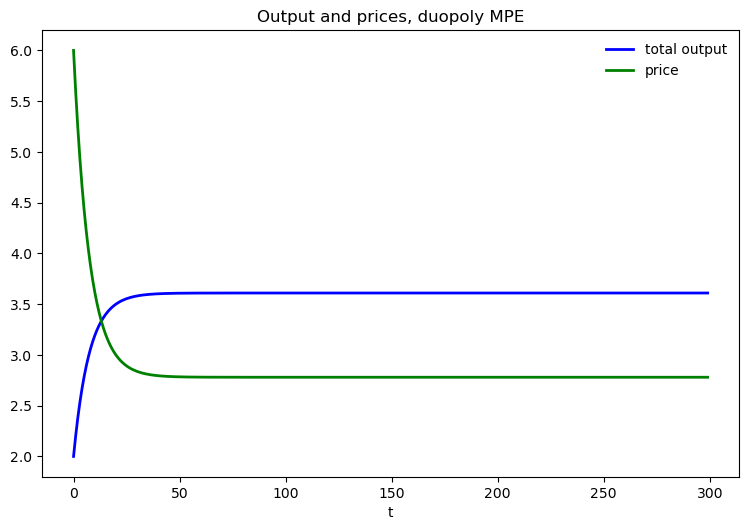

In [26]:
q1 = z[1, :]
q2 = z[2, :]
q = q1 + q2       # Total output, MPE
p = a0 - a1 * q   # Price, MPE

fig, ax = plt.subplots(figsize=(9, 5.8))
ax.plot(range(n), q, 'b-', lw=2, label='total output')
ax.plot(range(n), p, 'g-', lw=2, label='price')
ax.set_title('Output and prices, duopoly MPE')
ax.legend(frameon=False)
ax.set_xlabel('t')
plt.show()

In [27]:
# Computes the maximum difference between the two quantities of the two firms
np.max(np.abs(q1 - q2))

7.771561172376096e-15

In [28]:
# Compute values
u1 = (- F1 @ z).flatten()
u2 = (- F2 @ z).flatten()

π_1 = p * q1 - γ * (u1) ** 2
π_2 = p * q2 - γ * (u2) ** 2

v1_forward = np.sum(βs * π_1)
v2_forward = np.sum(βs * π_2)

v1_direct = (- z[:, 0].T @ P1 @ z[:, 0])
v2_direct = (- z[:, 0].T @ P2 @ z[:, 0])

# Display values
print("Computed values for firm 1 and firm 2:\n")
print(f"v1(forward sim) = {v1_forward:.4f}; v1 (direct) = {v1_direct:.4f}")
print(f"v2 (forward sim) = {v2_forward:.4f}; v2 (direct) = {v2_direct:.4f}")

Computed values for firm 1 and firm 2:

v1(forward sim) = 133.3303; v1 (direct) = 133.3296
v2 (forward sim) = 133.3303; v2 (direct) = 133.3296


In [29]:
# Sanity check
Λ1 = A - B2 @ F2
lq1 = qe.LQ(Q1, R1, Λ1, B1, beta=β)
P1_ih, F1_ih, d = lq1.stationary_values()

v2_direct_alt = - z[:, 0].T @ lq1.P @ z[:, 0] + lq1.d

(np.abs(v2_direct - v2_direct_alt) < tol2).all()

True

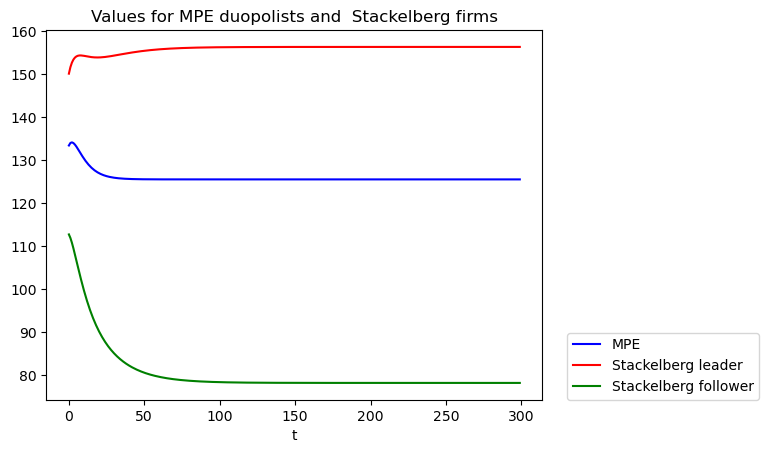

In [30]:
vt_MPE = np.zeros(n)
vt_follower = np.zeros(n)

for t in range(n):
    vt_MPE[t] = -z[:, t].T @ P1 @ z[:, t]
    vt_follower[t] = -yt_tilde[:, t].T @ P_tilde @ yt_tilde[:, t]

fig, ax = plt.subplots()
ax.plot(vt_MPE, 'b', label='MPE')
ax.plot(vt_leader, 'r', label='Stackelberg leader')
ax.plot(vt_follower, 'g', label='Stackelberg follower')
ax.set_title(r'Values for MPE duopolists and  Stackelberg firms')
ax.set_xlabel('t')
ax.legend(loc=(1.05, 0))
plt.show()

In [31]:
# Display values
print("Computed values:\n")
print(f"vt_leader(y0) = {vt_leader[0]:.4f}")
print(f"vt_follower(y0) = {vt_follower[0]:.4f}")
print(f"vt_MPE(y0) = {vt_MPE[0]:.4f}")

Computed values:

vt_leader(y0) = 150.0324
vt_follower(y0) = 112.6559
vt_MPE(y0) = 133.3296


In [32]:
# Compute the difference in total value between the Stackelberg and the MPE
vt_leader[0] + vt_follower[0] - 2 * vt_MPE[0]

-3.9709425620879415